In [27]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import trimesh
from trimesh.exchange.ply import parse_header, ply_binary


class MAP_FILTER():
    def __init__(self, path_2_ply='sample.ply', path_2_npz='sample1.npz'):
        self.obj = self.load_ply(path_2_ply)
        self.npz = self.load_npz(path_2_npz)
        self.voxel_size = self.npz['voxel_size']
        self.vertex_data = self.obj['vertex']['data'] 
        """`vertex data`
            * [vertex_id][x,y,z,r,g,b,alpha,semseg]
        """
        
        self.map_xy_size = int(self.get_max_xy())
        
        self.max_segment_index = 44

        # robot's parameters
        self.ROBOT_HEIGHT_MAX = 0.4
        self.ROBOT_HEIGHT_MIN = 0.25
        self.ROBOT_SIZE_XY = [0.5, 0.6]
        self.ROBOT_STEP_H_MAX = 0.15

        # maps
        self.floor_map = self.get_floor_2D_map()
        """ 
        return 2D array representing x and y axices of the map in `VOXELS`. \n
        value in a cell represents the height to floor from origin of coordinate system
        """
        self.map_z_size = int(round(self.get_max_floor_height() - self.get_min_floor_height() \
                         + self.ROBOT_HEIGHT_MAX/self.voxel_size))

        self.object_3d_occup_map = self.get_object_3d_occupency_map()
        """ return all other segments as a 3d occupency map in `VOXELS`"""
        

    def load_ply(self, path):
        with open(path, 'rb') as f:
            elements, is_ascii, image_name = parse_header(f)
            ply_binary(elements, f)
        return elements

    def load_npz(self, path):
        return np.load(path)

    def get_max_xy(self):
        max_x = 0
        max_y = 0
        for i in range(len(self.vertex_data)):
            if max_x < self.vertex_data[i][0]:
                max_x = self.vertex_data[i][0]
            if max_y < self.vertex_data[i][1]:
                max_y = self.vertex_data[i][1]
        return round(np.max((max_x, max_y )/self.voxel_size) + 1)

    def get_max_floor_height(self):
        """ return maximum value for height of the floor in `VOXELS`"""
        max_h = 0
        for i in range(self.floor_map.shape[0]):
            if max_h < np.max(self.floor_map[i,:]):
                max_h = np.max(self.floor_map[i,:])
        return max_h


    def get_min_floor_height(self):
        """ return minimum value for height of the floor in `VOXELS`"""
        min_h = 100000
        for i in range(self.floor_map.shape[0]):
            if min_h > np.max(self.floor_map[i,:]) and np.max(self.floor_map[i,:])!=0:
                min_h = np.max(self.floor_map[i,:])
        return min_h


    def extract_floor_coordinates(self):
        """ 
        get vertex coordinates belong to floor (floor semseg id is 2) in `METERS`
        """
        floor = []
        # get vertex coordinates belong to floor (floor semseg id is 2)
        for i in range(len(self.vertex_data)):
            if self.vertex_data[i][7] == 2: 
                floor.append([self.vertex_data[i][0], self.vertex_data[i][1], self.vertex_data[i][2]])
        floor = np.array(floor)
        return floor

    def extract_segment_coordinates(self, seg_no):
        """ common"""
        seg_coord = []
        for i in range(len(self.vertex_data)):
            if self.vertex_data[i][7] == seg_no:
                seg_coord.append([self.vertex_data[i][0], self.vertex_data[i][1], self.vertex_data[i][2]])
        seg_coord = np.array(seg_coord)
        return seg_coord
    
    def filter_map(self, seg_coord, floor_coord):
        seg_coord_new = [] 
        seg_coord = seg_coord/self.voxel_size
        floor_coord = floor_coord/self.voxel_size
        
        """
        return a new list of segmentations coordinates which are located 
        on the floor
        """
        print(len(seg_coord))
      
        for i in range(len(seg_coord)):
            
            #check if x and y are in the set of floor x and y
            if seg_coord[i, 0] in set(floor_coord[:, 0])and (seg_y in set(floor_coord[:, 1])):
#                 print("Seg:", seg_x, seg_y)
                seg_coord_new.append([seg_coord[i, 0], seg_coord[i, 1], seg_coord[i, 2]])
            else:
                continue
        
        return np.array(seg_coord_new)
        

    def get_floor_2D_map(self):
        """ 
        return 2D array representing x and y axices of the map in `VOXELS`. 
        value in a cell represents the height to floor from origin of coordinate system
        """
        # get coordinates of floor vertices (in meters)
        floor = self.extract_floor_coordinates()
        # scale floor coordinates to voxel size
        floor = floor/self.voxel_size
        # make empty 2D map (2D array of [max_axis_size][max_axis_size] for )
        floor_map = np.ones([self.map_xy_size, self.map_xy_size])*-1
        # 
        for i in range (len(floor)):
            x = int(round(floor[i, 0]))
            y = int(round(floor[i, 1]))
            floor_map[x,y] = floor[i, 2] 
        return floor_map

    

    def get_segment_3d_occupency_map(self, seg_no):
        """return 3d occupency map for a segment up to robot max height from the floor in `VOXELS` """
        coord = self.extract_segment_coordinates(seg_no)
        floor_coord = self.extract_floor_coordinates()
        # coord = self.filter_map(coord, floor_coord)
       
        coord = coord/self.voxel_size
        
        z_limit = self.map_z_size
        min_z = self.get_min_floor_height()
        max_z = self.get_max_floor_height() + round(self.ROBOT_HEIGHT_MAX/self.voxel_size) 
        map = np.zeros([self.map_xy_size, self.map_xy_size, z_limit])
        for i in range(len(coord)):
            x = int(round(coord[i,0]))
            y = int(round(coord[i,1]))
            z = round(coord[i,2])
            if  z > min_z and z<max_z:
                z = int(z - round(min_z) -1)
                map[x,y,z] = 1
        return map


    def get_object_3d_occupency_map(self):
        """ return all other segments as a 3d occupency map in `VOXELS` (except the floor)"""
        pc = np.zeros([self.map_xy_size, self.map_xy_size, self.map_z_size])
        for id in range(1, self.max_segment_index):
            pc = pc + self.get_segment_3d_occupency_map(id)
        return pc




In [31]:
map = MAP_FILTER()
print(map.map_xy_size)
floor_map = map.floor_map

obj_om = map.get_object_3d_occupency_map()

208


In [40]:
# obstacle map


obs_map = np.zeros([floor_map.shape[0], floor_map.shape[1]])
min_floor_h = map.get_min_floor_height()
floor_min_to_rob_min_h = map.get_min_floor_height() - map.ROBOT_HEIGHT_MIN/map.voxel_size
floor_min_to_rob_max_h = map.get_min_floor_height() - map.ROBOT_HEIGHT_MAX/map.voxel_size
vxl_size = map.voxel_size 
obstacles = []

                

for x in range(floor_map.shape[0]):
    for y in range(floor_map.shape[1]):
        for z in range(obj_om.shape[2]):
            if obj_om[x,y,z] != 0:
                obstacles.append((x, y, z))
            #take coordinates only for floor area
            if floor_map[x,y] != -1:
                 # floor to robot min height where floor exists
                if z <= floor_map[x,y] - floor_min_to_rob_min_h:
                    if obj_om[x,y,z] != 0:
                        obs_map[x,y] = -1 # occupied
                        
                # floor + robot min height to robot max height, if obs_map[x,y] is not yet occupied
                if z > floor_map[x,y] - floor_min_to_rob_min_h \
                and z < floor_map[x,y] - floor_min_to_rob_max_h:
                    # print('x')
                   
                    obs_map[x,y] = (z -(floor_map[x,y] - min_floor_h))*vxl_size # robot can move through adjesting its height to this value
            




41564


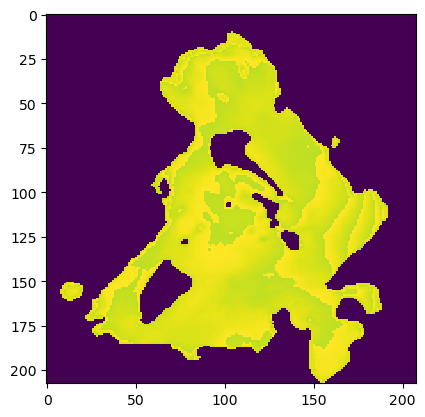

In [41]:
plt.imshow(obs_map), obs_map[150,100]
print(len(obstacles))